### website prototype notebook
Try to keep this code deployable as a web site, at least without too many changes.


Column
    [0] Row
        [0] Select(name='Column', options=['DATE', 'HourlyAltimeterS...], value='HourlyStationPressure')
        [1] Select(name='Method', options=['mean', 'min', 'max'], value='mean')
    [1] Matplotlib(Figure)
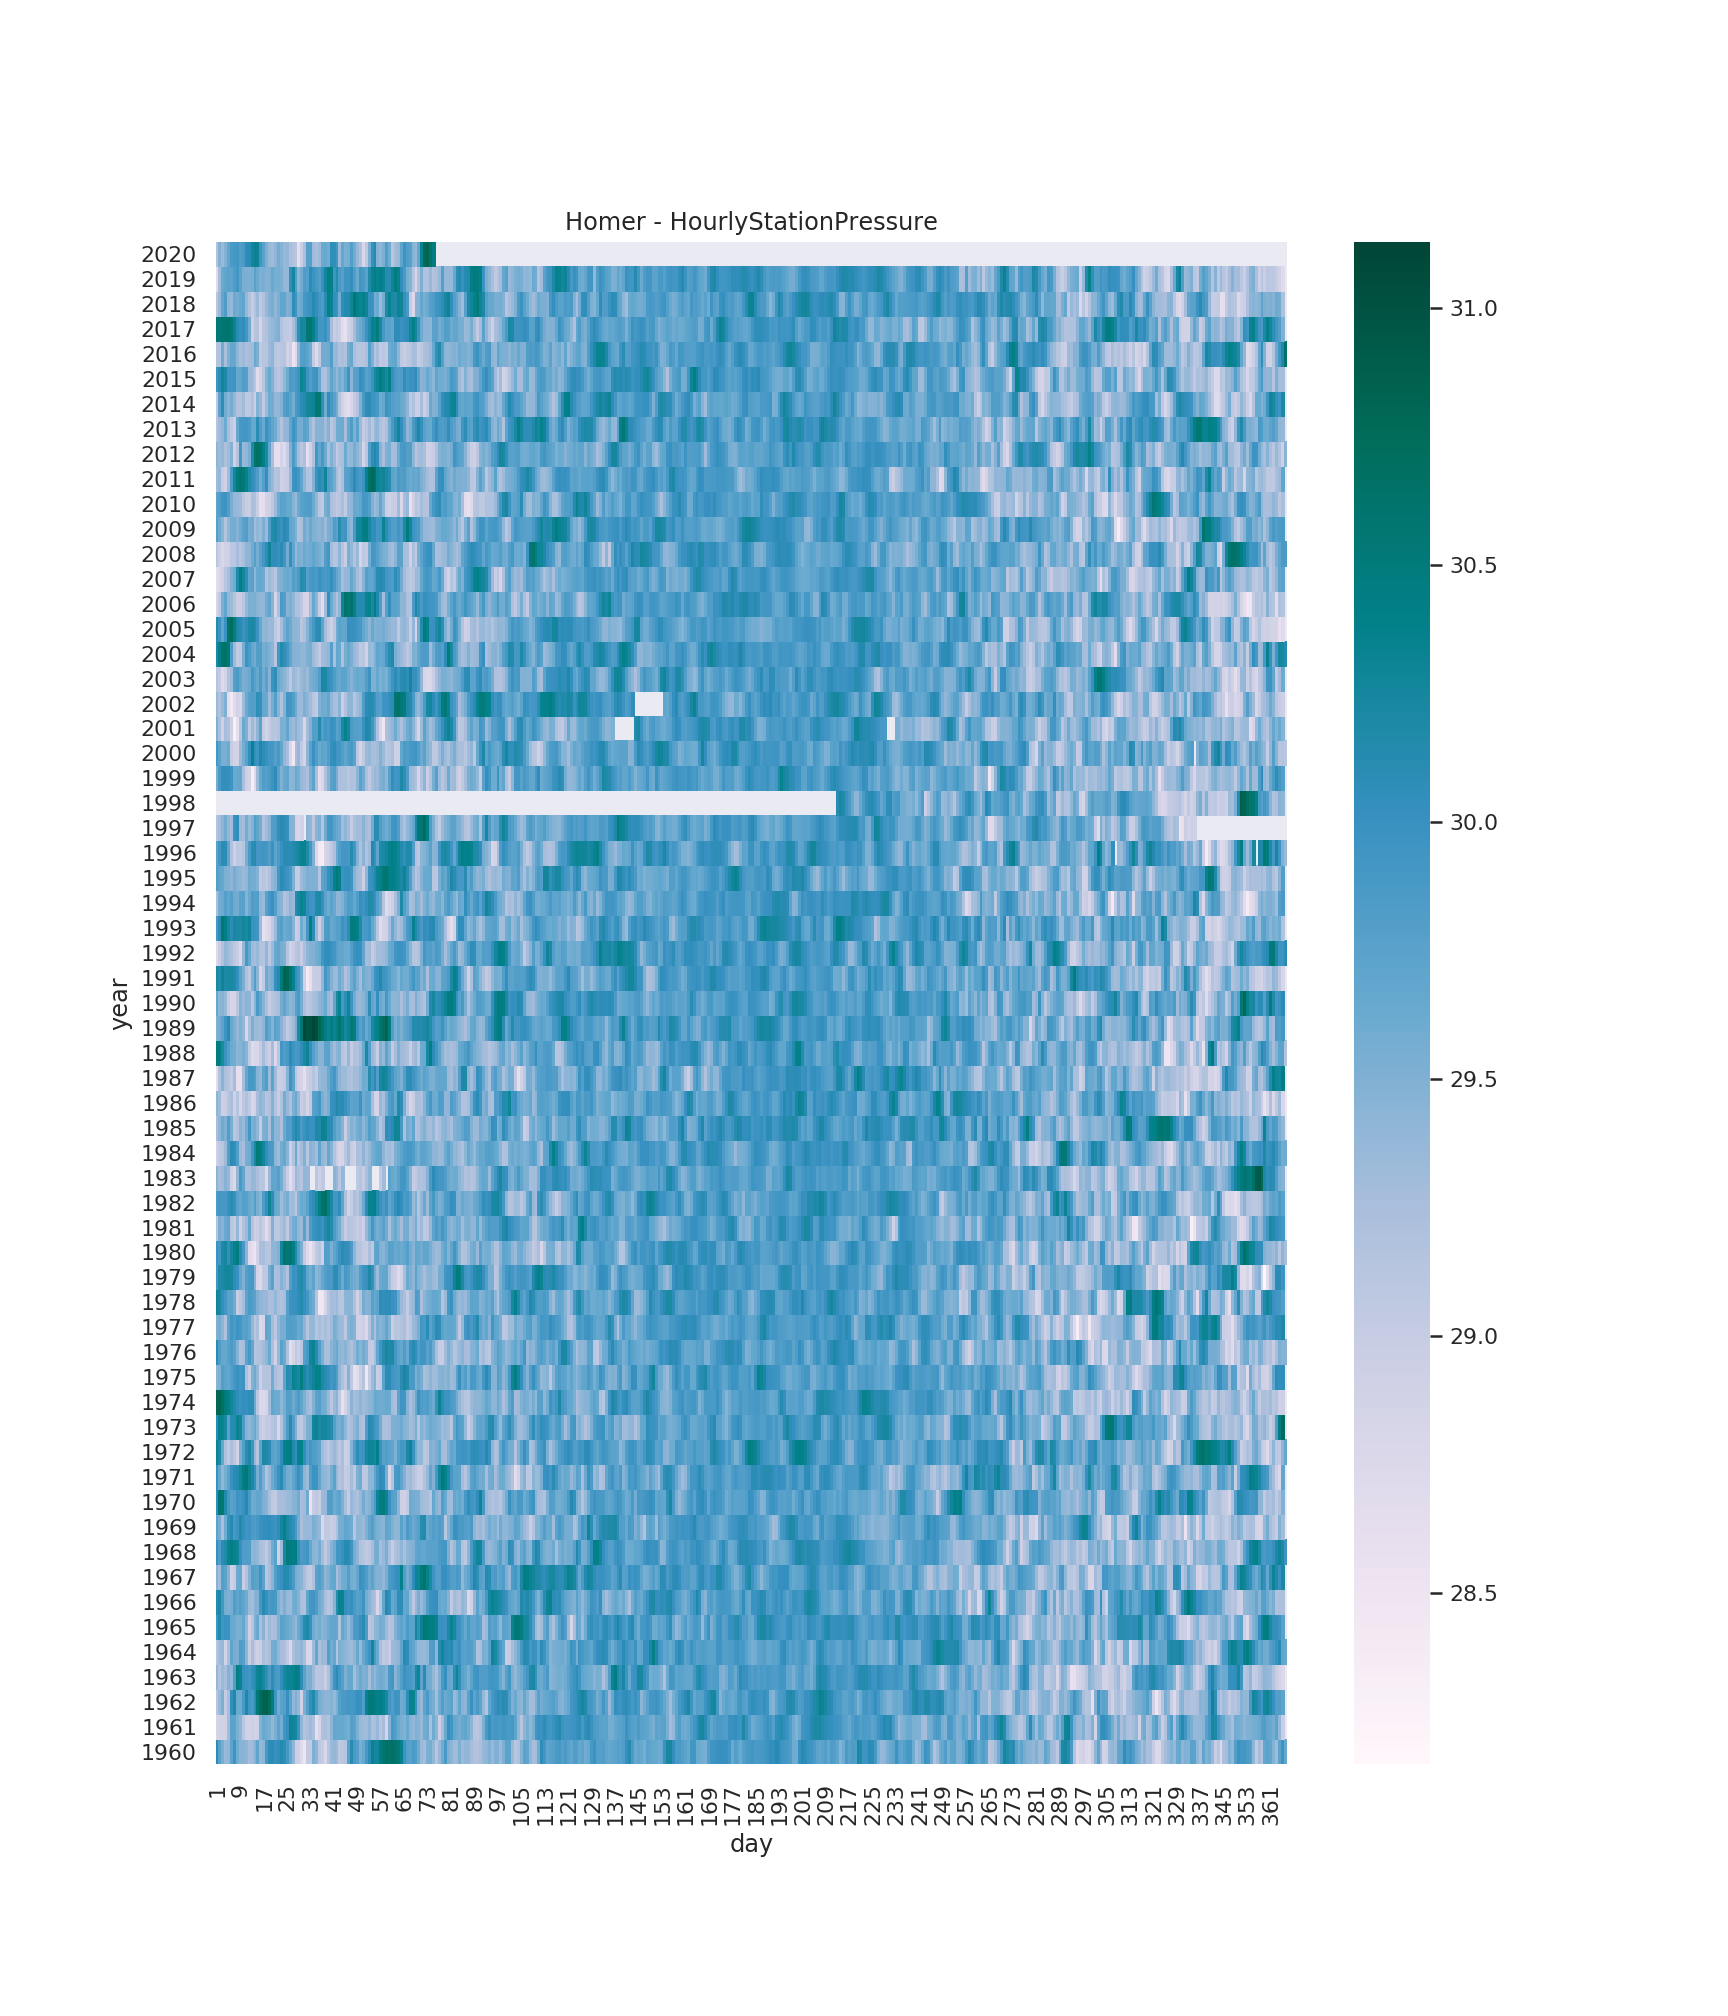

In [99]:
import re
import pandas as pd
import numpy as np
import sqlite3, errno, os
from matplotlib import pyplot
import seaborn
import panel as pn

#seaborn.set()
pn.extension()

#from tqdm import tqdm
#from pathlib import Path

def make_column_str( a ):
    the_str = ""
    for i in range( len(a) ):
        the_str += a[i]
        if i < len(a) - 1:
            the_str += ','

    return the_str

# connect
station_name = 'Homer'
conn = sqlite3.connect("../data/interim/lcd_daily.db")#, detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES )

# define main columns of interest and verify that they exist
main_column_list = ['DATE','HourlyAltimeterSetting','HourlyDewPointTemperature','HourlyDryBulbTemperature',
               'HourlyPrecipitation','HourlyPresentWeatherType','HourlyPressureChange','HourlyPressureTendency',               
               'HourlyRelativeHumidity','HourlySkyConditions','HourlySeaLevelPressure','HourlyStationPressure',
               'HourlyVisibility','HourlyWetBulbTemperature','HourlyWindDirection','HourlyWindGustSpeed',
               'HourlyWindSpeed']
 
cur = conn.cursor()
cur.execute( "SELECT %s FROM daily LIMIT 1" % make_column_str(main_column_list) ) # if this fails we got the columns wrong
cur.close()

# get some datas and graph
sql = "SELECT %s FROM daily ORDER BY DATE" % make_column_str(main_column_list)
homer = pd.read_sql(
        sql,
        con = conn,
        parse_dates={'DATE': '%Y-%m-%d %H:%M:%S'},
        index_col='DATE' )

#homer.set_index( 'DATE' )

# clean columns and create a dataframe for the heatmap
numeric_const_pattern = r"[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"

def objtofloat( a:object ):
    if type(a) == float:
        return a    
    
    if type(a) == str:
        b = re.search(numeric_const_pattern, a)
        if type(b) == type(None):
            return np.nan
        
        c = b.group()
        return float( c )
    
    return np.nan

def create_heat_df( column_a:str, method_a:str ):
    homer_clean = homer
    homer_clean[ column_a ] = homer_clean[ column_a ].apply( objtofloat )
    #homer.info()
    #homer['HourlyStationPressure'].value_counts()
    #homer[ "HourlyStationPressure" ].plot()

    # resample to Daily frequency
    heat_df = homer_clean[ [column_a] ]
    heat_df = heat_df.resample('D')
    if method_a == 'mean' :
        heat_df = heat_df.mean()
    elif method_a == 'min':
        heat_df = heat_df.min()
    else:
        heat_df = heat_df.max()
#    heat_df = method_a( heat_df ) # call aggregation method
    
    # create year and day columns and pivot
    heat_df['year'] = heat_df.index.year
    heat_df['day'] = heat_df.index.dayofyear
    heat_df = heat_df.pivot( index='year', columns='day', values=column_a )
    
    #heat_df.plot()    
    return heat_df

# create dropdown, init with HourlyStationPressure #11
column_init = main_column_list[11]
column_dropdown = pn.widgets.Select( name='Column', options=main_column_list, value=column_init )

method_names = [ 'mean', 'min', 'max' ]
method_name_init = method_names[0]
method_dropdown = pn.widgets.Select( name='Method', options=method_names, value=method_name_init )

def create_hmap( col_a:str, met_a ):
    hdf = create_heat_df( col_a, met_a )
    # create panel and plot
    fig = pyplot.figure(figsize=(12,14))
    ax = fig.subplots()
    ax.set_title( station_name + " - " + col_a )    
    #pyplot.title( station_name )    
    hmap = seaborn.heatmap( ax=ax, data=hdf, linewidths=0, cmap='PuBuGn' )
    ax.invert_yaxis()
    pyplot.close()
    return fig

@pn.depends( column_dropdown.param.value, watch=True )
def on_column( col_a ):
    current_method = method_dropdown.value
    main_pn[1] = create_hmap( col_a, current_method )

@pn.depends( method_dropdown.param.value, watch=True )
def on_method( met_name_a ):
    current_column = column_dropdown.value
    main_pn[1] = create_hmap( current_column, met_name_a )

main_pn = pn.Column(
    pn.Row( column_dropdown, method_dropdown ),
    create_hmap( column_init, method_name_init ) 
)
main_pn